In [2]:
import yfinance as yf
import pandas as pd

# Fetch historical data for BND, SPY, and TSLA
bnd_data = yf.download("BND", start="2015-01-01", end="2025-01-31")[['Close']]
spy_data = yf.download("SPY", start="2015-01-01", end="2025-01-31")[['Close']]
tsla_data = yf.download("TSLA", start="2015-01-01", end="2025-01-31")[['Close']]

# Rename columns for clarity
bnd_data.rename(columns={'Close': 'BND'}, inplace=True)
spy_data.rename(columns={'Close': 'SPY'}, inplace=True)
tsla_data.rename(columns={'Close': 'TSLA'}, inplace=True)

# Combine all data into one DataFrame
df = pd.concat([tsla_data, bnd_data, spy_data], axis=1)
df.dropna(inplace=True)  # Drop any missing values

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Compute daily returns
daily_returns = df.pct_change().dropna()

In [4]:
# Compute annual returns (assuming 252 trading days in a year)
annual_returns = daily_returns.mean() * 252
print("Annual Returns:")
print(annual_returns)

Annual Returns:
Price  Ticker
TSLA   TSLA      0.491944
BND    BND       0.015721
SPY    SPY       0.140314
dtype: float64


In [5]:
# Compute the covariance matrix
cov_matrix = daily_returns.cov() * 252
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
Price             TSLA       BND       SPY
Ticker            TSLA       BND       SPY
Price Ticker                              
TSLA  TSLA    0.326692  0.001785  0.046959
BND   BND     0.001785  0.002959  0.001048
SPY   SPY     0.046959  0.001048  0.030954


In [6]:
# Define initial weights (equal allocation)
import numpy as np


weights = np.array([1/3, 1/3, 1/3])

In [7]:
# Compute portfolio return
portfolio_return = np.sum(annual_returns * weights)

# Compute portfolio risk (standard deviation)
portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(f"Portfolio Return: {portfolio_return:.4f}")
print(f"Portfolio Risk: {portfolio_risk:.4f}")

Portfolio Return: 0.2160
Portfolio Risk: 0.2261


In [8]:
# Risk-free rate (assume 0 for simplicity)
risk_free_rate = 0

# Compute Sharpe Ratio
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.9552


In [9]:
from scipy.optimize import minimize

# Define the negative Sharpe Ratio (to maximize Sharpe Ratio)
def negative_sharpe_ratio(weights):
    portfolio_return = np.sum(annual_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    return -sharpe_ratio

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for _ in range(len(weights)))

# Initial guess (equal weights)
initial_guess = [1/3, 1/3, 1/3]

# Optimize
result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = result.x
print("Optimal Weights:")
print(optimal_weights)

Optimal Weights:
[0.14486319 0.48812007 0.36701674]


In [10]:
# Compute portfolio return and risk with optimal weights
optimal_portfolio_return = np.sum(annual_returns * optimal_weights)
optimal_portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimal_sharpe_ratio = (optimal_portfolio_return - risk_free_rate) / optimal_portfolio_risk

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Risk: {optimal_portfolio_risk:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Portfolio Return: 0.1304
Optimal Portfolio Risk: 0.1317
Optimal Sharpe Ratio: 0.9902


In [11]:
# Compute Value at Risk (VaR) at 95% confidence level
confidence_level = 0.95
portfolio_returns = daily_returns.dot(optimal_weights)
var_95 = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
print(f"Value at Risk (95% Confidence Level): {var_95:.4f}")

Value at Risk (95% Confidence Level): -0.0126


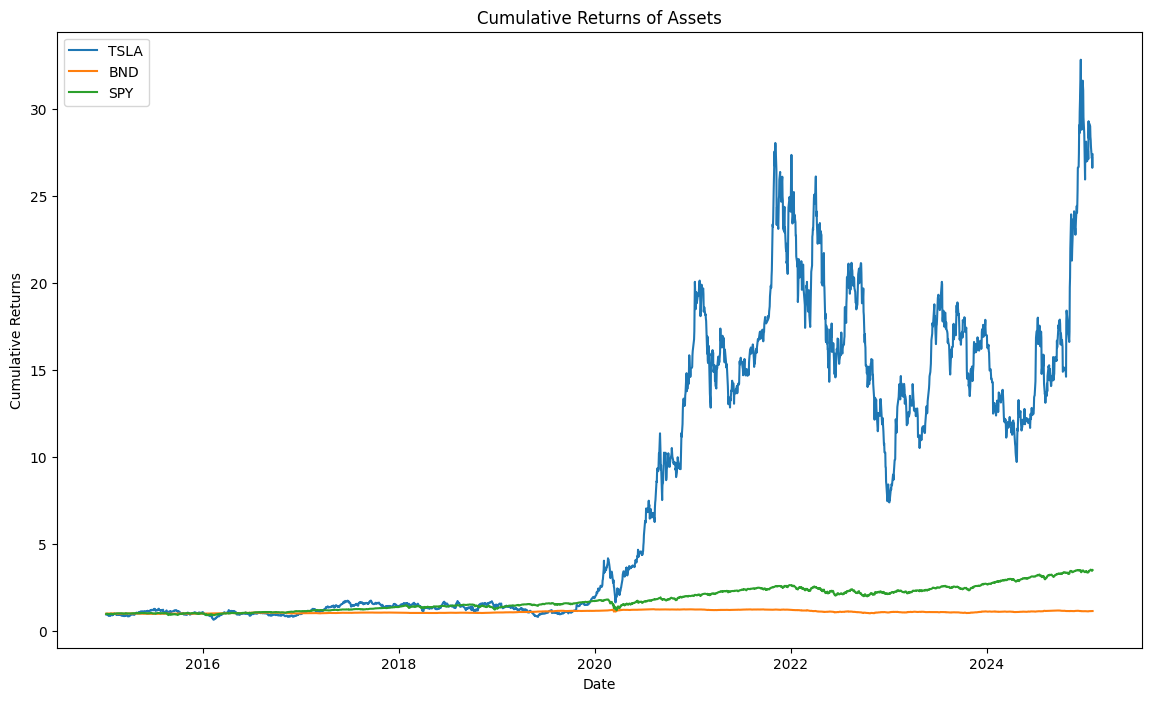

In [12]:
# Compute cumulative returns
from matplotlib import pyplot as plt


cumulative_returns = (1 + daily_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
plt.plot(cumulative_returns['TSLA'], label='TSLA')
plt.plot(cumulative_returns['BND'], label='BND')
plt.plot(cumulative_returns['SPY'], label='SPY')
plt.title('Cumulative Returns of Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

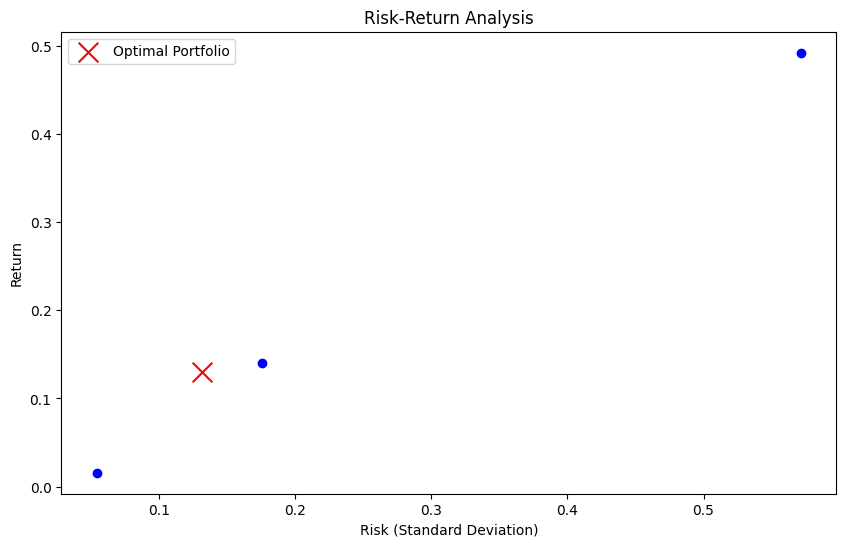

In [13]:
# Plot risk-return scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(np.sqrt(np.diag(cov_matrix)), annual_returns, color='blue')
plt.scatter(optimal_portfolio_risk, optimal_portfolio_return, color='red', marker='x', s=200, label='Optimal Portfolio')
plt.title('Risk-Return Analysis')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()